In [1]:
config_path = './results/new_design/config.yaml'
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import src.ASM as ASM
import src.math_tool as mt
import src.img_tool as it
from PIL import Image
import yaml
from box import Box
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
time_string = datetime.now().isoformat(timespec='minutes')
################################################## all code in unit of μm
config = None
with open(config_path, 'r') as f:
    config = Box(yaml.safe_load(f))
π, λ = np.pi, 0.532
k = np.array(2*π/λ).astype(np.float32)
x_start, x_end, y_start, y_end, z_start, z_end = tuple(config.simulation.range)
Lx, Ly, Lz = x_end - x_start, y_end - y_start, z_end - z_start
Nx_ticks, Ny_ticks, Nz_ticks = tuple(config.plot.N_ticks) 
z_batch_size = eval(config.simulation.z_batch_size)
s_res = config.simulation.resolution
Nx, Ny, Nz = eval(s_res[0]), eval(s_res[1]), eval(s_res[2]) # manufactured aperture have resolution of 1000 * 1000
# xs, ys, zs = np.linspace(x_start, x_end, Nx, endpoint=False), np.linspace(y_start, y_end, Ny, endpoint=False), np.linspace(z_start, z_end, Nz, endpoint=False)
xs, ys, zs = np.linspace(x_start, x_end, Nx, endpoint=False, dtype=np.float32), np.linspace(y_start, y_end, Ny, endpoint=False, dtype=np.float32), np.linspace(z_start, z_end, Nz, endpoint=False, dtype=np.float32)
x_ticks, x_ticks_val, y_ticks, y_ticks_val, z_ticks, z_ticks_val = np.arange(0, Nx, Nx/Nx_ticks), np.round(xs[::Nx//Nx_ticks], decimals=config.plot.dp), np.arange(0, Ny, Ny/Ny_ticks), np.round(ys[::Ny//Ny_ticks], decimals=config.plot.dp), np.arange(0, Nz, Nz/Nz_ticks), np.round(zs[::Nz//Nz_ticks], decimals=config.plot.dp)
# print(f'storage requirement: {Nx * Ny * Nz * 128 / 8 / 1024 / 1024 / 1024} GB')
# print(f'float32 (intensity) requirement: {Nx * Ny * Nz * 32 / 8 / 1024 / 1024 / 1024} GB')
# print(f'z-resolution: {(z_end - z_start)/Nz}μm')
# print(f'config file: {config_path}')
# A_xy = np.load(f'{path}/A.npy')
ND = 20
Nθs = 32
D_start, D_end = 30e3, 50e3
Ds = np.linspace(D_start, D_end, ND, endpoint=False, dtype=np.float32)
ND_ticks = 5
D_ticks, D_ticks_val = np.arange(0, ND, ND/ND_ticks), np.linspace(D_start, D_end, ND_ticks, endpoint=False, dtype=np.float32)
θ0s = np.linspace(0, 2*π, Nθs, endpoint=False, dtype=np.float32)
x, y = np.meshgrid(xs, ys, indexing='ij')
def cal_distance(x, y, D): #calculate distance from set x, y, to (0, 0, D)
    '''
        x, y <2d array>
        D <1d array>
    return
        <3d array> # Nx, Ny, ND
    '''
    return np.sqrt( D**2 + mt.r(x, y, 0, 0)[..., None]**2)
print()
print(f'Nx={Nx}, Ny={Ny}, ND={ND}, Nθs={Nθs}')
print(f'float32 memory requirement: {32*Nx*Ny*ND*Nθs/8/1024**3}GB')


Nx=512, Ny=512, ND=20, Nθs=32
float32 memory requirement: 0.625GB


In [2]:
import src.apertures as apertures
θ = np.mod(k*cal_distance(x, y, Ds), np.float32(2*π)) #Nx, Ny, ND

cos_θ_θ0s = np.cos(θ[..., None]-θ0s) # Nx, Ny, ND, Nθs
mask = apertures.block_edge_mask(512, 512, radius=250) # Nx, Ny # radius of 500μm under resolution of 2μm = 250 pixel
aperture = (cos_θ_θ0s > 0) * mask[..., None, None] # aperture only selects location that have constructive contribution to θ0

In [4]:
selective_contribution_E = (cos_θ_θ0s * aperture).sum(axis=(0,1)) # ND, Nθs
# above D = 32μm, difference in drop off at r=0 and r=500μm have less than 0.1% difference, thus is ignored
E2 = selective_contribution_E**2 # ND, Nθs
print(E2.max(axis=1)) # ND
print(E2.min(axis=1)) # ND

[4.0782881e+09 4.3514153e+09 4.4869105e+09 4.1599803e+09 4.0115707e+09
 4.2490831e+09 4.4906209e+09 4.5893248e+09 4.3743539e+09 3.9747794e+09
 4.0776886e+09 4.2807649e+09 4.4996224e+09 4.6882908e+09 4.7225124e+09
 4.5529969e+09 4.2581079e+09 3.9158559e+09 4.0776819e+09 4.2584041e+09]
[3.5853773e+09 3.3706388e+09 3.5500516e+09 3.7441080e+09 3.6981274e+09
 3.3575808e+09 3.3103188e+09 3.4885496e+09 3.6772101e+09 3.8737792e+09
 3.5713244e+09 3.2882788e+09 3.1811261e+09 3.2727916e+09 3.4222802e+09
 3.5800589e+09 3.7396460e+09 3.8991892e+09 3.5706908e+09 3.2893676e+09]


In [6]:
optimal_focal_θ0_idx = E2.argmax(axis=1) # ND
optimal_focal_θ0 = θ0s[optimal_focal_θ0_idx] # optimal phase for focus at D (aperture is designed to produce maximal intensity at focus with phase θ0)
optimal_aperture = aperture[:, :, np.arange(ND), optimal_focal_θ0_idx] # Nx, Ny, ND, optimal aperture config for each z location

phasor_θ = np.exp(1j*θ, dtype=np.complex64) #Nx, Ny, ND (ND is for z test point)
trailing_phase = np.empty((ND, ND), dtype=np.complex64) # ND (focal position), ND (phase test position)
for i_D_focal in range(ND):
    trailing_phase[i_D_focal] = (phasor_θ * optimal_aperture[..., i_D_focal][..., None]).sum(axis=(0,1)) # (Nx, Ny, ND) * (Nx, Ny, 1)
trailing_phase = np.angle(trailing_phase) # ND (focal position), ND (phase test position)
cos_trail_optimal_phase_diff = np.cos(np.mod(trailing_phase - optimal_focal_θ0[:, None], np.float32(2*π))) # (ND (focal position), ND (phase test position)) - (ND (focal position), 1)

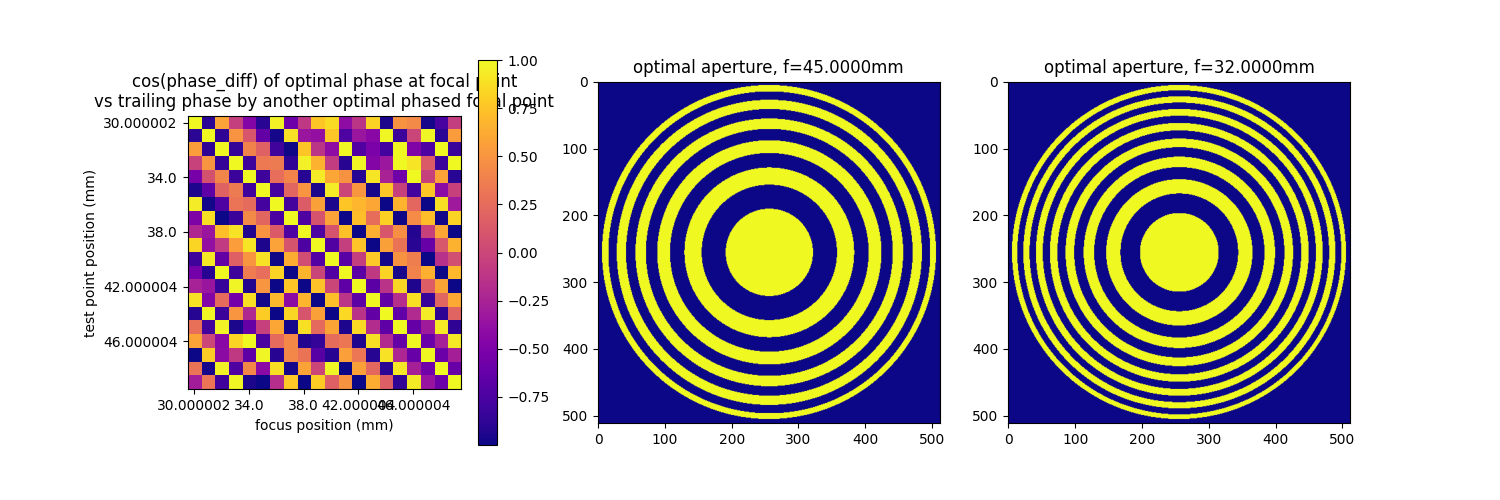

In [12]:

plt.cla()
layout = [[0, 1, 2]]
fig, ax = plt.subplot_mosaic(layout, figsize=(15, 5))
tmp = ax[0].imshow(cos_trail_optimal_phase_diff.T, cmap='plasma')
ax[0].set_title(f'cos(phase_diff) of optimal phase at focal point\nvs trailing phase by another optimal phased focal point')
ax[0].set_xlabel(f'focus position (mm)')
ax[0].set_ylabel(f'test point position (mm)')
ax[0].set_xticks(D_ticks, D_ticks_val*1e-3)
ax[0].set_yticks(D_ticks, D_ticks_val*1e-3)
ax[1].imshow(optimal_aperture[..., -5].T, cmap='plasma')
ax[2].imshow(optimal_aperture[..., 2].T, cmap='plasma')
ax[1].set_title(f'optimal aperture, f={(Ds[-5]*1e-3):.4f}mm')
ax[2].set_title(f'optimal aperture, f={(Ds[2]*1e-3):.4f}mm')
fig.colorbar(tmp)
plt.show()
plt.savefig(f'{save_path}/f32f45_analysis.png', dpi=300)

In [7]:
print(cos_trail_optimal_phase_diff[-5])
# observe that cos_trail_optimal_phase_diff[-1, 3] = 0.9989
# phase optimal for intensity at f=Ds[-1] and f=Ds[3] interfere constructively

[ 0.49005154 -0.823215    0.9980253   0.9999998  -0.56966615 -0.03900937
  0.6656397  -0.99167275  0.46651372  0.30102825  0.48490888 -0.96506226
  0.8420316  -0.16504243 -0.64721787  0.99999636 -0.61867356 -0.23022003
  0.9175284  -0.8700241 ]


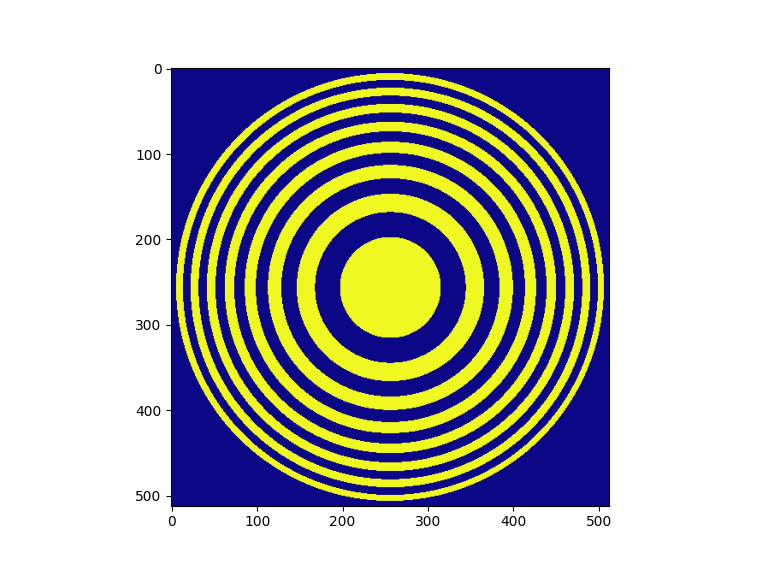

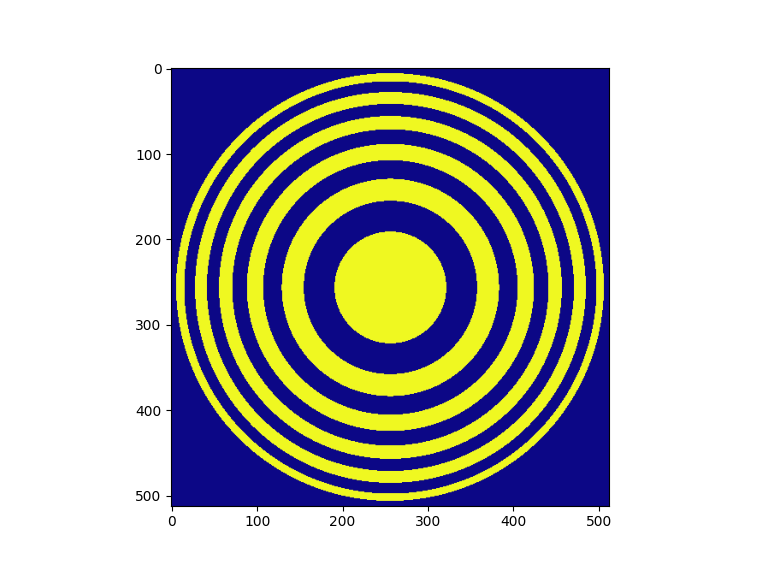

In [10]:
save_path = './aperture/tmp/'
plt.cla()
plt.imshow(optimal_aperture[..., 2].T, cmap='plasma')
plt.show()
plt.savefig(f'{save_path}/f32.png', dpi=300, bbox_inches='tight')
plt.cla()
plt.imshow(optimal_aperture[..., -5].T, cmap='plasma')
plt.show()
plt.savefig(f'{save_path}/f45.png', dpi=300, bbox_inches='tight')

In [11]:
np.save(f'{save_path}/f45.npy', optimal_aperture[..., -5])
np.save(f'{save_path}/f32.npy', optimal_aperture[..., 2])